In [1]:
folder_path = f"/home/jhongfongfah/PYTORCH_PROJ/[Hong] week04"

# Object Detection

The goal of object detection is to find a target object from images.  It can be implemented as a function whch returns
1. **[AABB]** the four corners of the axis-aligned bounding box,
2. **[CIRCLE]** the center and the radius, or
3. **[MAP]** the confidence map (heatmap image) representing how likely the object exists at each pixel,
for example.

The following cell loads an NPY file which contains
* `IMG`: a 300x300 image each of which has a hiragana and kanjis,
* `LABEL`: the hiragana class ID in each image,
* `MOJI`: the hiragana in each image, and
* `BBOX`: the bounding box $(X, Y, W, H)$ of the hiragana in each image. $(X, Y$) and $(X+W, Y+H)$ denote the top-left and bottom-right corner respectively.


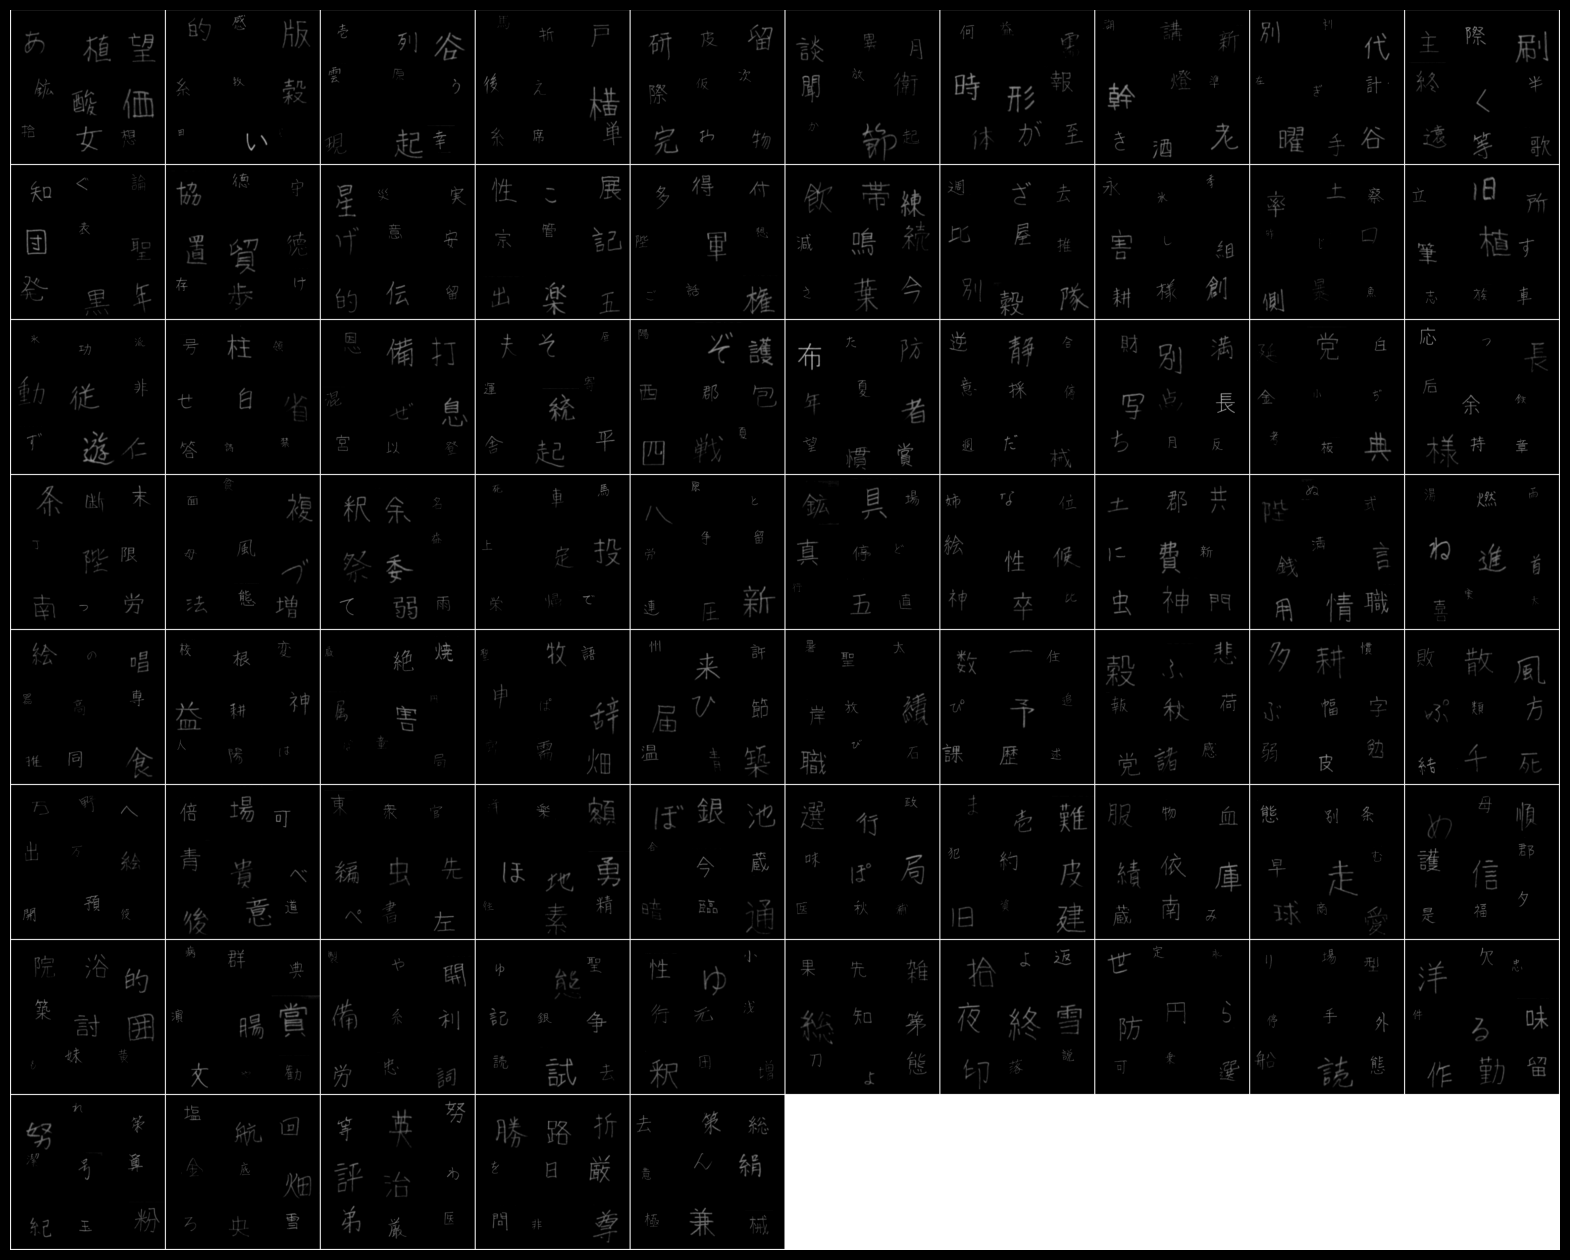

MOJI = き


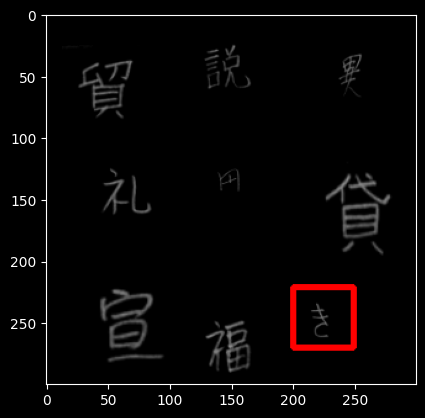

In [4]:
import numpy as np
import torch
from torch import nn
import torchvision
import matplotlib.pyplot as plt
import cv2
from tqdm.notebook import tqdm
import PIL
from PIL import Image

SKIP=10
assert 160 % SKIP == 0

DATA = np.load(f'{folder_path}/Practice_DNN/ETL8G_300x300.npz')

# 300x300 images, 75 hiragana classes, 160 images per class
IMG = DATA['img']

# the label [0:74] of each image.
LABEL = DATA['label'].astype(np.int64)

# the hiragana in each image
MOJI = DATA['moji']

# the bounding box (X, Y, W, H) of the hiragana in each image (X and Y defines the top-left corner of the box in the image)
BBOX = DATA['bbox']

if SKIP > 1:
    IMG = IMG[::SKIP,:,:]
    LABEL = LABEL[::SKIP]
    MOJI = MOJI[::SKIP]
    BBOX = BBOX[::SKIP]

# show thumbnails
plt.figure(figsize=(20.0, 20.0))
grid = torchvision.utils.make_grid(torch.from_numpy(IMG[::160//SKIP,None,:,:].astype(float) / 255), nrow=10, pad_value=1)
plt.imshow(grid.clamp(0, 1).permute(1, 2, 0).expand(-1, -1, 3).cpu().numpy(), cmap='gray')
plt.axis('off')
plt.show()


def show_image_bbox(ax, gray_img, bbox):
    if np.max(gray_img) <= 1.0:
        gray_img = gray_img * 255
    bgr = cv2.cvtColor(gray_img.astype(np.uint8), cv2.COLOR_GRAY2BGR)
    bgr = cv2.rectangle(bgr, (bbox[0], bbox[1]), (bbox[0]+bbox[2], bbox[1]+bbox[3]), (255, 0, 0), 3)
    ax.imshow(bgr)


# show an image with bbox
idx = 123
print(f"MOJI = {MOJI[idx]}")
fig, ax = plt.subplots(1,1)
show_image_bbox(ax, IMG[idx,:,:], BBOX[idx,:])
plt.show()

# Exercise

Train a NN that detects the hiragana in an input image.

Notice that to train a NN for AABB, we need a sort of MSE loss evaluating the difference of the ground truth and a predicted bboxes. It can be defined as

  * the difference of the four elements of bbox $(X, Y, H, W)$ as is,
  * Euclidean distances between the bbox corners, or
  * IoU (intersection over union) of bboxes.

Similarly, a NN for circle requires a loss evaluating the difference of circles.  The ground truth circle should be converted by the user before defining the dataset.

To implement a NN that returns a confidence map, we need to prepare a ground truth confidence map from the ground truth bbox.  We can simply convert a bbox to a 2D Gaussian whose sigma is equal to the radius of the minimum circle enclosing the bbox.
